# Imports

In [1]:
import os
import pickle
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import normalize
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time  # Optional, to slow down updates a little

# Path Declaration

In [2]:
project_base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
project_base_path

'/home/ANONYMOUS/projects/FALCON'

In [3]:
saved_v1_generated_data_path = os.path.join(project_base_path, "data/generation/snort/snort3-community-rules_v1.pkl")
saved_v1_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/snort/snort3-community-rules_v1.pkl'

In [4]:
saved_v2_generated_data_path = os.path.join(project_base_path, "data/generation/snort/snort3-community-rules_v2.pkl")
saved_v2_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/snort/snort3-community-rules_v2.pkl'

# Environment Setup

In [5]:
# ⚙️ Config
RULE_MODEL_NAME = "/data/common/models/sentence-transformers/all-MiniLM-L6-v2"
CTI_MODEL_NAME = "/data/common/models/sentence-transformers/all-MiniLM-L6-v2"

BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
MAX_LEN = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
###########################
RUN = 0
FINE_TUNED_MODEL_NAME = "all-MiniLM-L6-v2"

FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
        
MODEL_SAVE_PATH = os.path.join(project_base_path, f"script/fine_tuning/dual-encoder/snort/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}")

# Load Dataset

In [6]:
def load_from_pickle(file_path) -> dict:
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [7]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [8]:
# Load the data back from the pickle file
loaded_v1_data = load_from_pickle(saved_v1_generated_data_path)
print(len(loaded_v1_data.keys()))

4017


In [9]:
snort_cti_sample_dict = get_first_n_elements(loaded_v1_data, 10)

In [10]:
# Load the data back from the pickle file
loaded_v2_data = load_from_pickle(saved_v2_generated_data_path)
print(len(loaded_v2_data.keys()))

4017


In [11]:
snort_cti_sample_dict

{'alert tcp $HOME_NET 2589 -> $EXTERNAL_NET any ( msg:"MALWARE-BACKDOOR - Dagger_1.4.0"; flow:to_client,established; content:"2|00 00 00 06 00 00 00|Drives|24 00|",depth 16; metadata:ruleset community; classtype:misc-activity; sid:105; rev:14; )': '    Title: Detection of Dagger 1.4.0 Backdoor Activity Over TCP\n\n    Threat Category: Malware – Backdoor\n\n    Threat Name: Dagger 1.4.0\n\n    Detection Summary:\n\n    This signature is designed to detect network traffic associated with the Dagger 1.4.0 backdoor. The traffic is characterized by a specific sequence of bytes ("2|00 00 00 06 00 00 00|Drives|24 00|") found within the first 16 bytes of the data payload. This communication occurs from an infected internal host to an external destination and typically indicates unauthorized remote access capabilities.\n\n    Rule Metadata\n    Classification: Misc Activity\n\n    Ruleset: Community\n\n    Rule Logic Breakdown\n    Alert Type: alert\n\n    Protocol: tcp\n\n    Source IP: $HOME_

In [12]:
snorts, ctis = zip(*snort_cti_sample_dict.items())
snorts = list(snorts)
ctis = list(ctis)

In [13]:
len(snorts), len(ctis)

(10, 10)

In [14]:
def format_cti_snort_data_to_training_data(data: list[dict]) -> list[tuple]:
    """
    Format the CTI Snort data into training data.

    :param data: The data to format
    :return: Formatted training data
    """
    training_data = []
    for dataset in data:
        for key, value in dataset.items():
            training_data.append((key, value))
    return training_data

In [15]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = format_cti_snort_data_to_training_data([loaded_v1_data, loaded_v2_data])
print(len(full_dataset))

8034


In [16]:
def remove_10_test_samples(training_data: list[tuple], test_pairs: dict) -> list[tuple]:
    # Extract all test keys and values into sets for quick lookup
    test_keys = set(test_pairs.keys())
    test_values = set(test_pairs.values())
    
    # Filter training data
    filtered_data = [(key, value) for key, value in training_data if key not in test_keys and value not in test_values]
    
    return filtered_data

In [17]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = remove_10_test_samples(full_dataset, snort_cti_sample_dict)
print(len(full_dataset))

8014


In [18]:
# Split into training and testing sets (80% train, 20% test)
train_pairs, test_pairs = train_test_split(full_dataset, test_size=0.1, random_state=SEED)

# Training Setup

In [19]:
# Custom Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, rule_tokenizer, cti_tokenizer):
        self.data = data
        self.tokenizer_rule = rule_tokenizer  # e.g., for rules
        self.tokenizer_cti = cti_tokenizer  # e.g., for cti

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor, positive = self.data[idx]
        encoded_rule = self.tokenizer_rule(anchor, padding="max_length", truncation=True,
                                     max_length=MAX_LEN, return_tensors="pt")
        encoded_cti = self.tokenizer_cti(positive, padding="max_length", truncation=True,
                                     max_length=MAX_LEN, return_tensors="pt")
        return {
            "input_ids_rule": encoded_rule["input_ids"].squeeze(0),
            "attention_mask_rule": encoded_rule["attention_mask"].squeeze(0),
            "input_ids_cti": encoded_cti["input_ids"].squeeze(0),
            "attention_mask_cti": encoded_cti["attention_mask"].squeeze(0),
        }

In [20]:
# Dual Encoder Model
class DualEncoderModel(nn.Module):
    def __init__(self, model_name_rule, model_name_cti):
        super().__init__()
        self.encoder_rule = AutoModel.from_pretrained(model_name_rule)  # e.g., rule
        self.encoder_cti = AutoModel.from_pretrained(model_name_cti)  # e.g., cti

    def forward(self, input_ids_rule, attention_mask_rule, input_ids_cti, attention_mask_cti):
        out_rule = self.encoder_rule(input_ids=input_ids_rule, attention_mask=attention_mask_rule)
        out_cti = self.encoder_cti(input_ids=input_ids_cti, attention_mask=attention_mask_cti)

        emb_rule = out_rule.last_hidden_state[:, 0]  # CLS
        emb_cti = out_cti.last_hidden_state[:, 0]

        emb_rule = nn.functional.normalize(emb_rule, p=2, dim=1)  # Normalize for cosine similarity
        emb_cti = nn.functional.normalize(emb_cti, p=2, dim=1)  # Normalize for cosine similarity

        return emb_rule, emb_cti

In [21]:
# Contrastive Loss (InfoNCE / NT-Xent)
def contrastive_loss(emb_rule, emb_cti, temperature=0.05):
    similarity_matrix = torch.matmul(emb_rule, emb_cti.T) / temperature
    labels = torch.arange(len(emb_rule)).to(emb_cti.device)
    return nn.CrossEntropyLoss()(similarity_matrix, labels)


# Training 

In [22]:
# Training Loop
def train():
    tokenizer_rule = AutoTokenizer.from_pretrained(RULE_MODEL_NAME)  # e.g., rule tokenizer
    tokenizer_cti = AutoTokenizer.from_pretrained(CTI_MODEL_NAME)  # e.g., cti tokenizer

    training_dataset = ContrastiveDataset(train_pairs, tokenizer_rule, tokenizer_cti)
    loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = DualEncoderModel(RULE_MODEL_NAME, CTI_MODEL_NAME).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    epoch_losses = []

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
            input_ids_rule = batch["input_ids_rule"].to(DEVICE)
            attention_mask_rule = batch["attention_mask_rule"].to(DEVICE)
            input_ids_cti = batch["input_ids_cti"].to(DEVICE)
            attention_mask_cti = batch["attention_mask_cti"].to(DEVICE)

            emb_rule, emb_cti = model(input_ids_rule, attention_mask_rule, input_ids_cti, attention_mask_cti)
            loss = contrastive_loss(emb_rule, emb_cti)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        epoch_losses.append((epoch + 1, avg_loss))
        print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")

        clear_output(wait=True)
        epochs, losses = zip(*epoch_losses)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, losses, marker='o')
        plt.title("Loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

        time.sleep(0.1)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("Training complete! Model saved.")
    return epoch_losses


### Run 0 - [Batch 16 | Epoch 5]

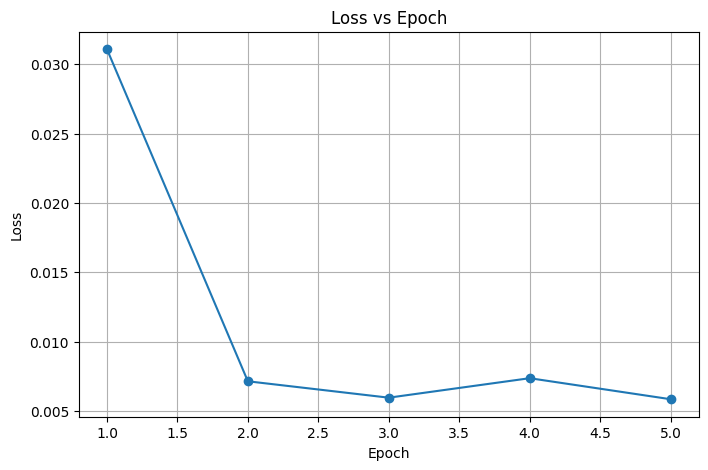

Training complete! Model saved.


In [23]:
# Run training
loss_vs_epoch = train()

In [24]:
loss_vs_epoch

[(1, 0.0310911760329782),
 (2, 0.007141709816251688),
 (3, 0.0059597848160284),
 (4, 0.007364923456846891),
 (5, 0.005848447431079959)]

### Run 1 - [Batch 100 | Epoch 10]

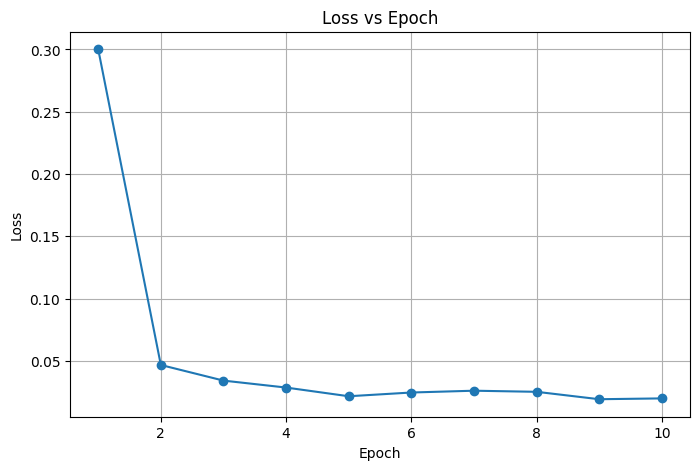

Training complete! Model saved.


In [23]:
# Run training
loss_vs_epoch = train()

In [24]:
loss_vs_epoch

[(1, 0.3001920886462146),
 (2, 0.04673327561483833),
 (3, 0.034196068699414245),
 (4, 0.028618789662101483),
 (5, 0.021640811868465254),
 (6, 0.024638413636600725),
 (7, 0.02608787576910762),
 (8, 0.025197693729041182),
 (9, 0.019252127212271323),
 (10, 0.019913506400109627)]

### Run 2 - [Batch 70 | Epoch 30]

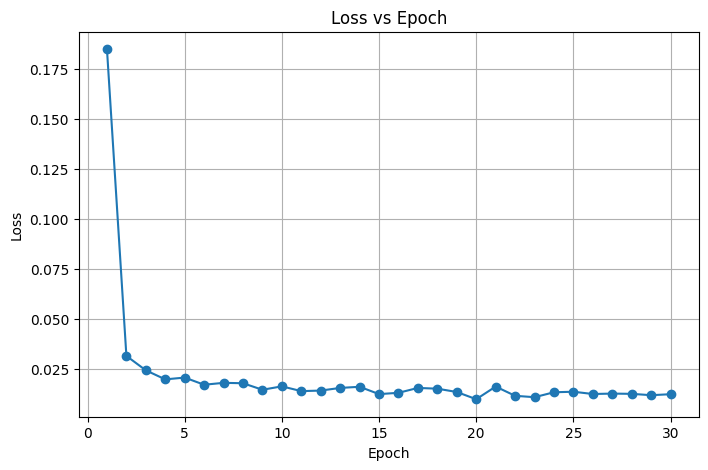

Training complete! Model saved.


In [23]:
# Run training
loss_vs_epoch = train()

In [24]:
loss_vs_epoch

[(1, 0.18473082891964274),
 (2, 0.0313082183017189),
 (3, 0.024096596175765556),
 (4, 0.019574558230276515),
 (5, 0.020474313073252624),
 (6, 0.016891450666968504),
 (7, 0.017838076168931575),
 (8, 0.017644079253211833),
 (9, 0.014378602858834291),
 (10, 0.016085083835389032),
 (11, 0.01369268956756068),
 (12, 0.013973917475090922),
 (13, 0.01529605113654716),
 (14, 0.015870183800868284),
 (15, 0.012198120039993928),
 (16, 0.012855683726509316),
 (17, 0.01529873776150973),
 (18, 0.014912603267941468),
 (19, 0.01326117491122694),
 (20, 0.009644640384059664),
 (21, 0.015979096994459898),
 (22, 0.01135441224652403),
 (23, 0.010661351339455049),
 (24, 0.013125681357311035),
 (25, 0.013389302440582075),
 (26, 0.012252788413939278),
 (27, 0.012464810580866015),
 (28, 0.012331729602009909),
 (29, 0.011661300774803224),
 (30, 0.01215065694437866)]

# Evaluation

In [25]:
# Load tokenizer
tokenizer_rule = AutoTokenizer.from_pretrained(RULE_MODEL_NAME)  # e.g., rule tokenizer
tokenizer_cti = AutoTokenizer.from_pretrained(CTI_MODEL_NAME)  # e.g., cti tokenizer

# Load model
model = DualEncoderModel(RULE_MODEL_NAME, CTI_MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
# model.eval()

<All keys matched successfully>

In [26]:
tokenized_snorts = tokenizer_rule(snorts, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)
tokenized_ctis = tokenizer_cti(ctis, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)

In [27]:
tokenized_snorts['input_ids'].shape, tokenized_snorts['attention_mask'].shape

(torch.Size([10, 178]), torch.Size([10, 178]))

In [28]:
input_ids_snorts = tokenized_snorts["input_ids"].to(DEVICE)
attention_mask_snorts = tokenized_snorts["attention_mask"].to(DEVICE)
input_ids_ctis = tokenized_ctis["input_ids"].to(DEVICE)
attention_mask_ctis = tokenized_ctis["attention_mask"].to(DEVICE)   

In [29]:
emb_snorts, emb_ctis = model(input_ids_snorts, attention_mask_snorts, input_ids_ctis, attention_mask_ctis)

In [30]:
emb_snorts.shape, emb_ctis.shape

(torch.Size([10, 384]), torch.Size([10, 384]))

In [31]:
# Step 2: Compute dot product matrix [num_desc x num_rules]
dot_product_matrix = torch.matmul(emb_ctis, emb_snorts.T)

# Step 3: Apply softmax along rules axis (dim=1), to get attention weights from each description to all rules
attention_weights = F.softmax(dot_product_matrix, dim=1).detach().cpu().numpy()

# Plot Attention

### Run 0 [Batch 16 | Epoch 5]

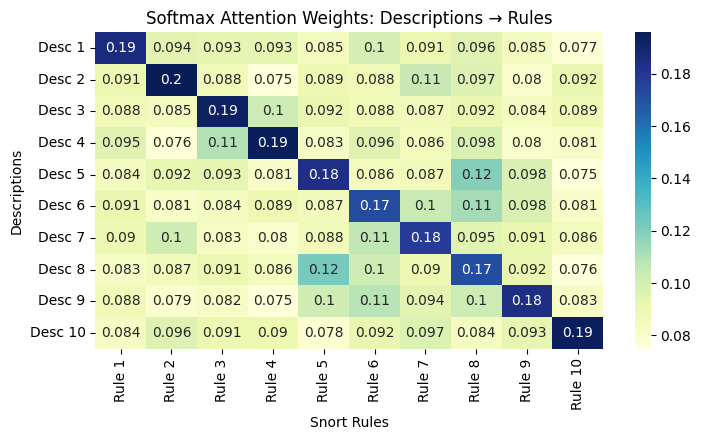

In [32]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(snorts))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("Snort Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

### Run 1 - [Batch 100 | Epoch 10]

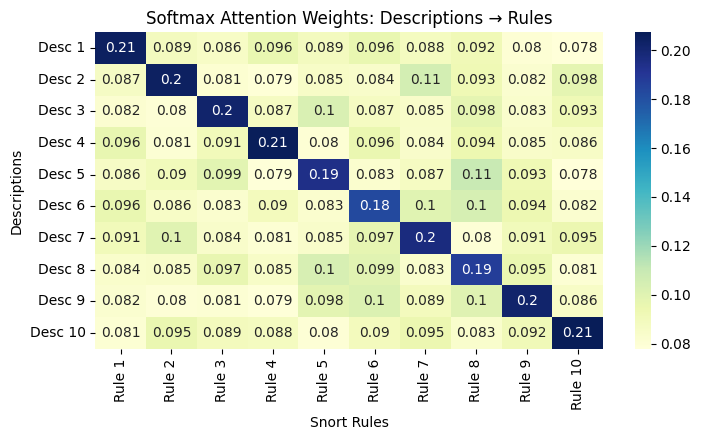

In [32]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(snorts))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("Snort Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

### Run 2 - [Batch 70 | Epoch 30]

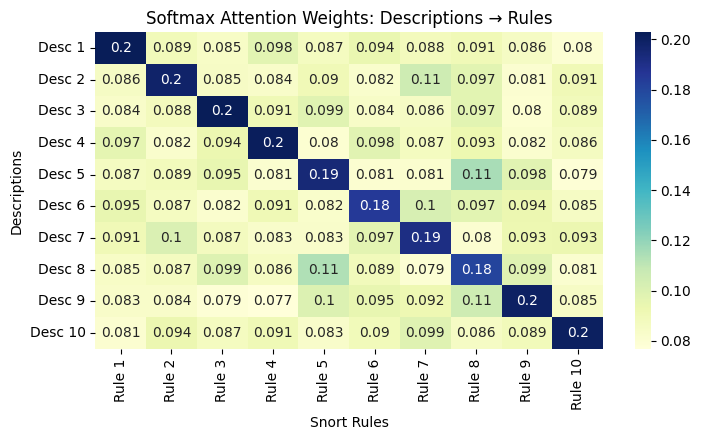

In [32]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(snorts))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("Snort Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()